# Graphs for Rapport

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import holidays


In [2]:
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        hourly_intervals = pd.date_range(
            start=start.floor('1h'), end=end.ceil('1h'), freq='1h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    hourly_df = pd.DataFrame(hourly_rows)

    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(
        hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - \
        pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='1h')
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    return hourly_df


def add_features(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  df['IsHoliday'] = df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Energy_Consumption_1h'] = df['Energy_Consumption'].shift(1)
  df['Energy_Consumption_6h'] = df['Energy_Consumption'].shift(6)
  df['Energy_Consumption_12h'] = df['Energy_Consumption'].shift(12)
  df['Energy_Consumption_24h'] = df['Energy_Consumption'].shift(24)
  df['Energy_Consumption_1w'] = df['Energy_Consumption'].shift(24*7)
  df['Energy_Consumption_rolling'] = df['Energy_Consumption'].rolling(window=24).mean()

  return df


def filter_data(start_date, end_date, data):
    return data[(data.index >= start_date) & (data.index <= end_date)].copy()


# Define the start and end dates
start_date = pd.to_datetime('2021-05-30')
end_date = pd.to_datetime('2023-05-30')

# Load the data
data = pd.read_csv('Preprocessing/TestDataset/CleanedColoradoData.csv')

# Convert to quarterly data
hourly_df = convert_to_hourly(data=data)

# Add features
feature_df = add_features(hourly_df)

# Filter the data
final_df = filter_data(start_date, end_date, feature_df)

print(final_df.head(24))

                     Energy_Consumption  Session_Count  Day_of_Week  \
2021-05-30 00:00:00            1.345740              1            6   
2021-05-30 01:00:00            1.345740              1            6   
2021-05-30 02:00:00            1.345740              1            6   
2021-05-30 03:00:00            1.345740              1            6   
2021-05-30 04:00:00            1.345740              1            6   
2021-05-30 05:00:00            1.345740              1            6   
2021-05-30 06:00:00            1.345740              1            6   
2021-05-30 07:00:00            1.345740              1            6   
2021-05-30 08:00:00            4.741189              6            6   
2021-05-30 09:00:00            7.253527              3            6   
2021-05-30 10:00:00            4.195423              2            6   
2021-05-30 11:00:00            3.809077              2            6   
2021-05-30 12:00:00            8.711293              3            6   
2021-0

In [3]:
# Info about the dataset
# Total charging station using data 
data.sort_index(inplace=True)

# First data in the dataset
first_data = data['Start_DateTime'].min()
print(f'First data in the dataset: {first_data}')

# Last data in the dataset
last_data = data['Start_DateTime'].max()
print(f'Last data in the dataset: {last_data}')

total_charging_stations = len(data['Station_Name'].unique())
print(f'Total charging stations using data: {total_charging_stations}')

First data in the dataset: 2018-01-01 17:49:00
Last data in the dataset: 2023-11-30 23:27:00
Total charging stations using data: 50


# Plots 

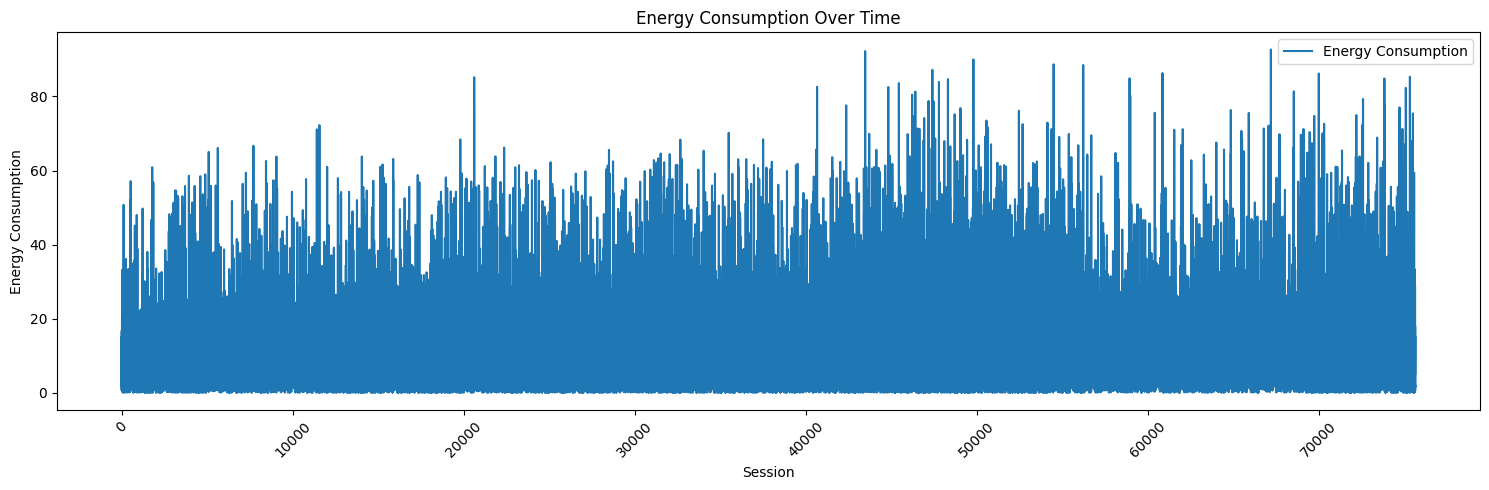

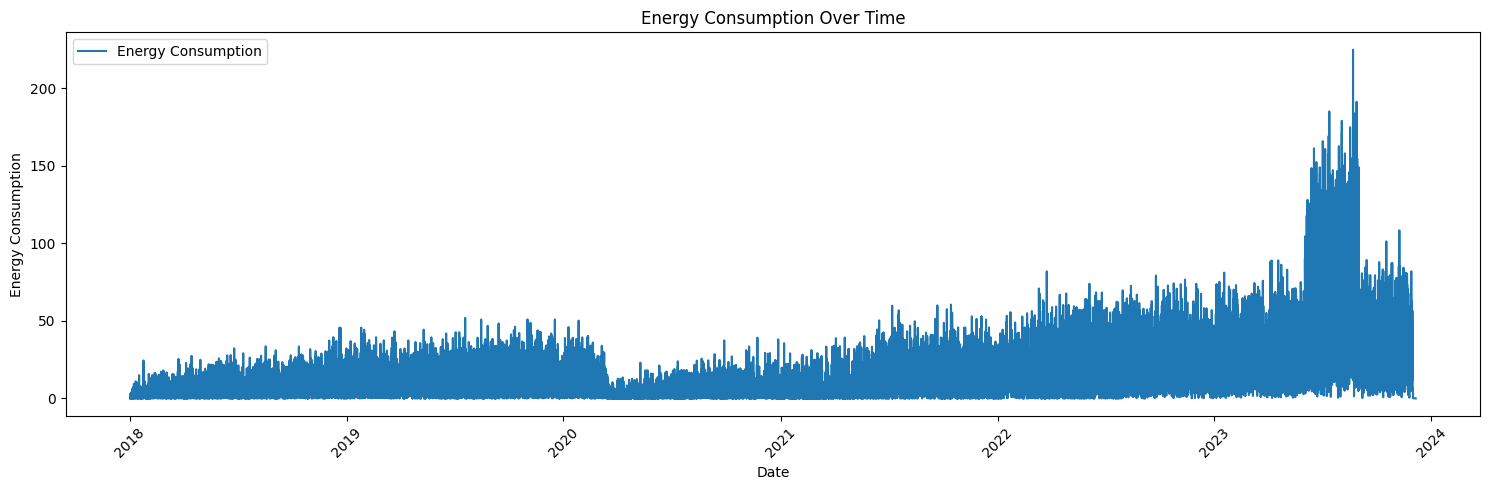

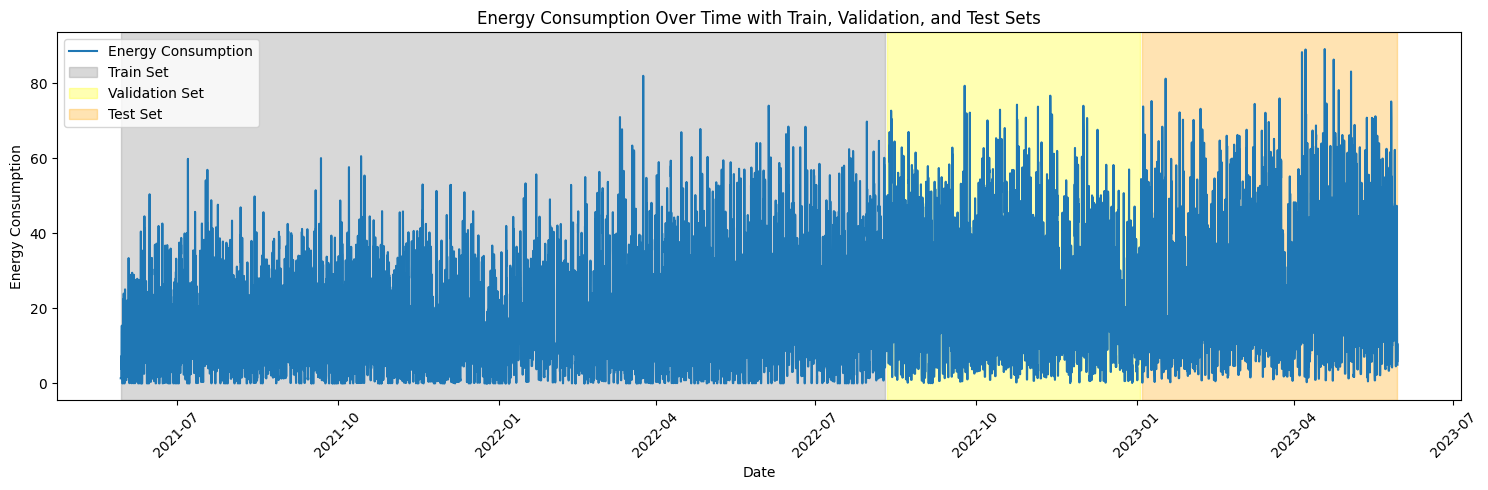

In [4]:
#Plot the data
plt.figure(figsize=(15, 5))
plt.plot(data.index,data['Energy_Consumption'], label='Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.xlabel('Session')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../Report/Figures/Colorado/Energy_Consumption_Sessions.png')
plt.show()

# Plot the entire dataset
plt.figure(figsize=(15, 5))
plt.plot(feature_df.index, feature_df['Energy_Consumption'], label='Energy Consumption')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../Report/Figures/Colorado/Energy_Consumption_Hourly.png')
plt.show()


train_start_date = pd.to_datetime('2021-05-30')
train_end_date = pd.to_datetime('2022-08-10')
val_start_date = pd.to_datetime('2022-08-11')
val_end_date = pd.to_datetime('2023-01-03')
test_start_date = pd.to_datetime('2023-01-04')
test_end_date = pd.to_datetime('2023-05-30')



# Plot the filtered dataset with colored regions for train, validation, and test sets
plt.figure(figsize=(15, 5))
plt.plot(final_df.index, final_df['Energy_Consumption'], label='Energy Consumption')
plt.axvspan(train_start_date, train_end_date, color='grey', alpha=0.3, label='Train Set')
plt.axvspan(val_start_date, val_end_date, color='yellow', alpha=0.3, label='Validation Set')
plt.axvspan(test_start_date, test_end_date, color='orange', alpha=0.3, label='Test Set')
plt.title('Energy Consumption Over Time with Train, Validation, and Test Sets')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../Report/Figures/Colorado/Energy_Consumption_Train_Validation_Test.png')
plt.show()

# Analysis 

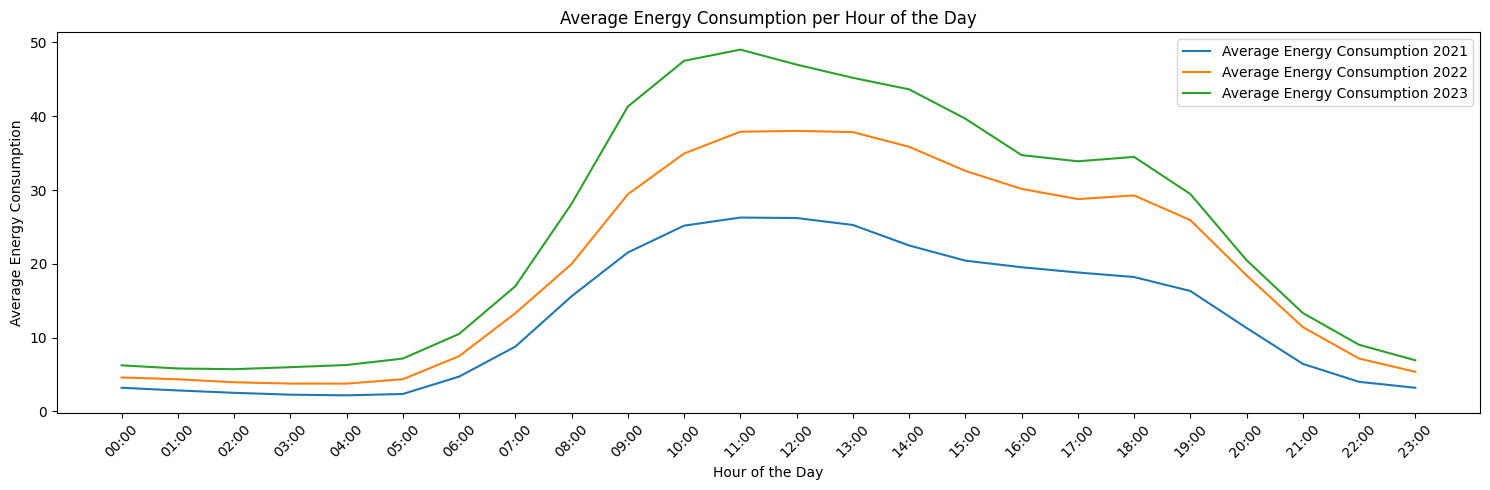

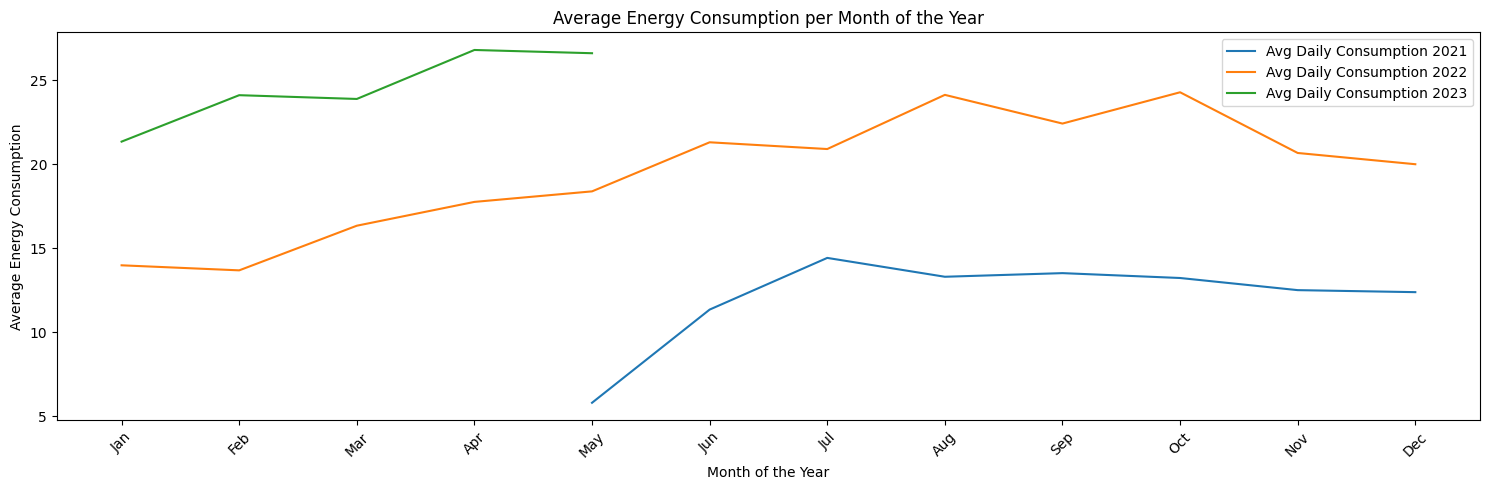

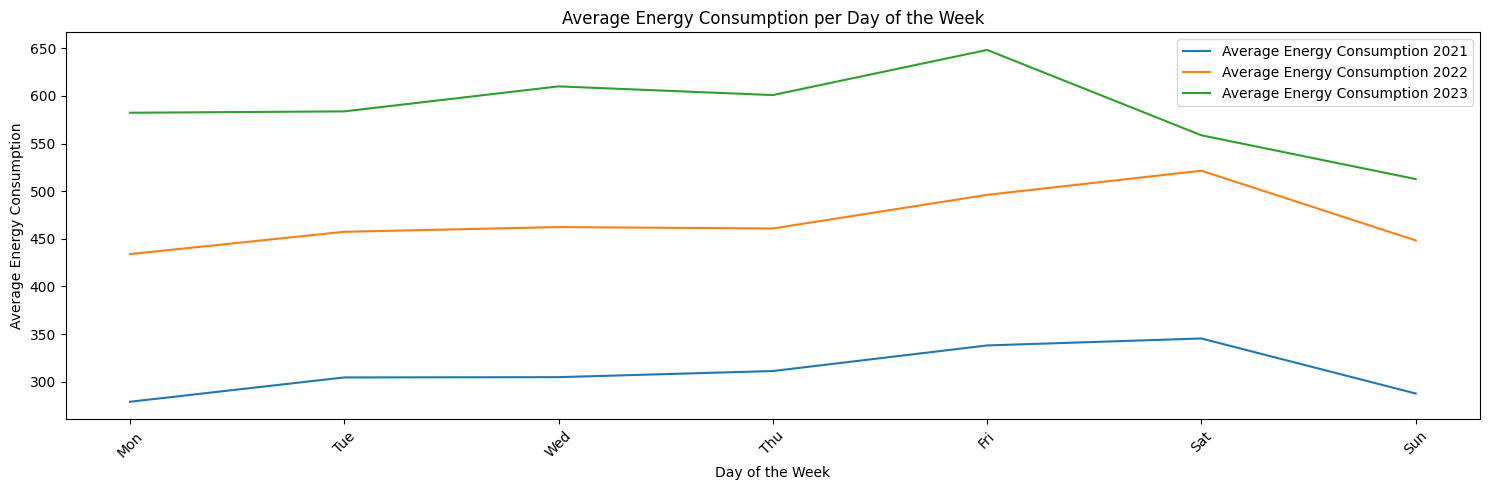

In [5]:
# Plot the average energy consumption per hour of the day for each year plot all in one 

x_names = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00',
           '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']
plt.figure(figsize=(15, 5))
for year in final_df['Year'].unique():
    hourly_avg = final_df[final_df['Year'] == year].groupby(
        'Hour_of_Day')['Energy_Consumption'].mean()
    plt.plot(hourly_avg.index, hourly_avg.values,
             label=f'Average Energy Consumption {year}')

plt.title(f'Average Energy Consumption per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption')
plt.xticks(ticks=range(24), labels=x_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../Report/Figures/Colorado/Colorado_Average_Energy_Consumption_per_Hour.png', dpi=1200)
plt.show()



#### Montly ####
monthly_avg = final_df.groupby(['Year', 'Month_of_Year'])['Energy_Consumption'].mean().reset_index()

x_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
           'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


plt.figure(figsize=(15, 5))
for year in monthly_avg['Year'].unique():
    ydata = monthly_avg[monthly_avg['Year'] == year]
    plt.plot(ydata['Month_of_Year'], ydata['Energy_Consumption'], label=f'Avg Daily Consumption {year}')
plt.title(f'Average Energy Consumption per Month of the Year')
plt.xlabel('Month of the Year')
plt.ylabel('Average Energy Consumption')
plt.xticks(ticks=range(1, 13), labels=x_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



# Day of the week average energy consumption for each year
x_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create a 'Date' column by extracting the date part from the index of final_df
final_df['Date'] = final_df.index.date
daily_df = final_df.groupby(['Year', 'Date'])['Energy_Consumption'].sum().reset_index()

# Extract day of week
daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df['Day_of_Week'] = daily_df['Date'].dt.dayofweek 

# Avg daily consumption 
weekly_avg = daily_df.groupby(['Year', 'Day_of_Week'])['Energy_Consumption'].mean().reset_index()

plt.figure(figsize=(15, 5))
for year in weekly_avg['Year'].unique():
    weekly_avg = daily_df[daily_df['Year'] == year].groupby(
        'Day_of_Week')['Energy_Consumption'].mean()
    plt.plot(weekly_avg.index, weekly_avg.values,
             label=f'Average Energy Consumption {year}')
plt.title(f'Average Energy Consumption per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Consumption')
plt.xticks(ticks=range(7), labels=x_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('../Report/Figures/Colorado/Colorado_Average_Energy_Consumption_per_Day.png', dpi=1200)
plt.show()

C:\Users\caspe\AppData\Local\Temp\ipykernel_30468\364291494.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(final_df[feature_df['Year'] == year].index, final_df[final_df['Year'] == year]['Energy_Consumption'], label=f'Energy Consumption {year}')


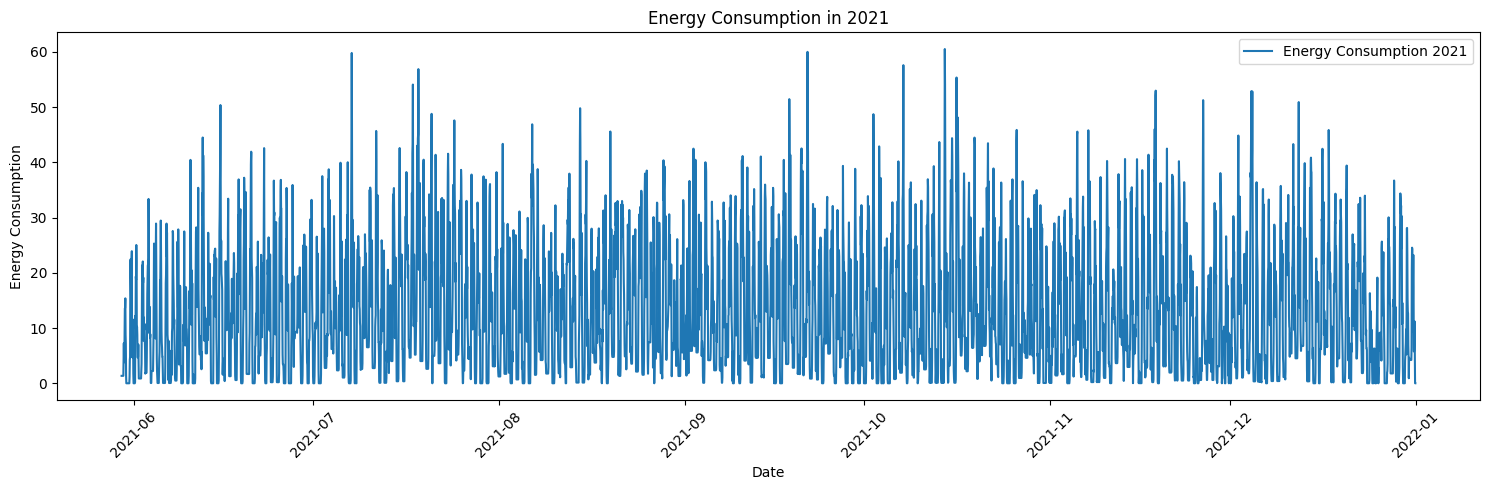

C:\Users\caspe\AppData\Local\Temp\ipykernel_30468\364291494.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(final_df[feature_df['Year'] == year].index, final_df[final_df['Year'] == year]['Energy_Consumption'], label=f'Energy Consumption {year}')


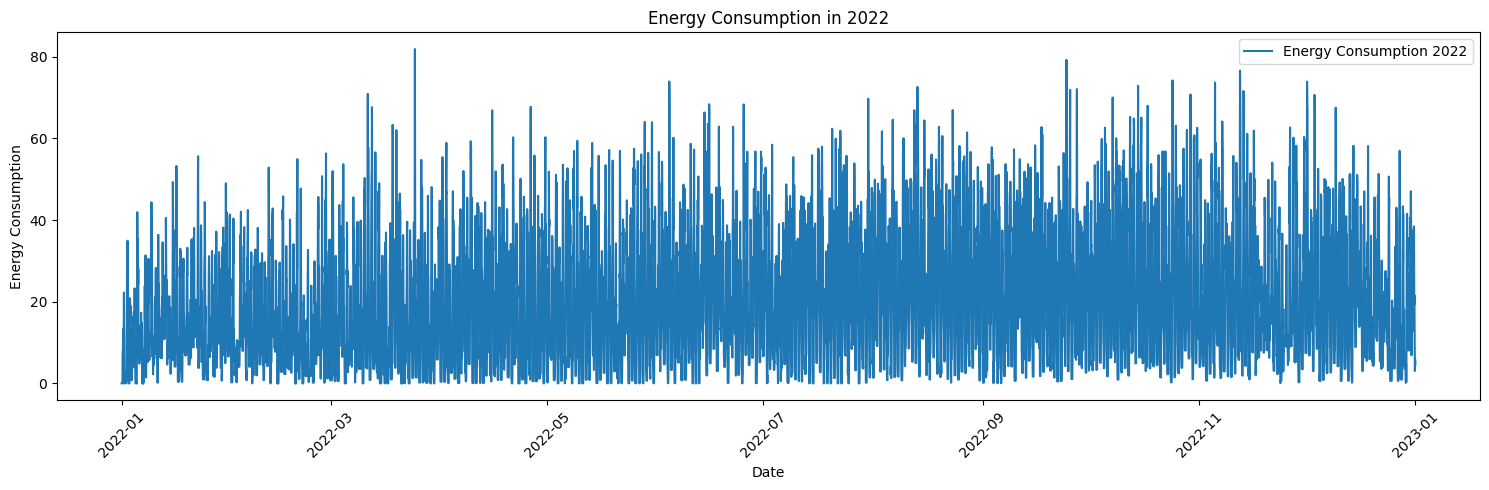

C:\Users\caspe\AppData\Local\Temp\ipykernel_30468\364291494.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.plot(final_df[feature_df['Year'] == year].index, final_df[final_df['Year'] == year]['Energy_Consumption'], label=f'Energy Consumption {year}')


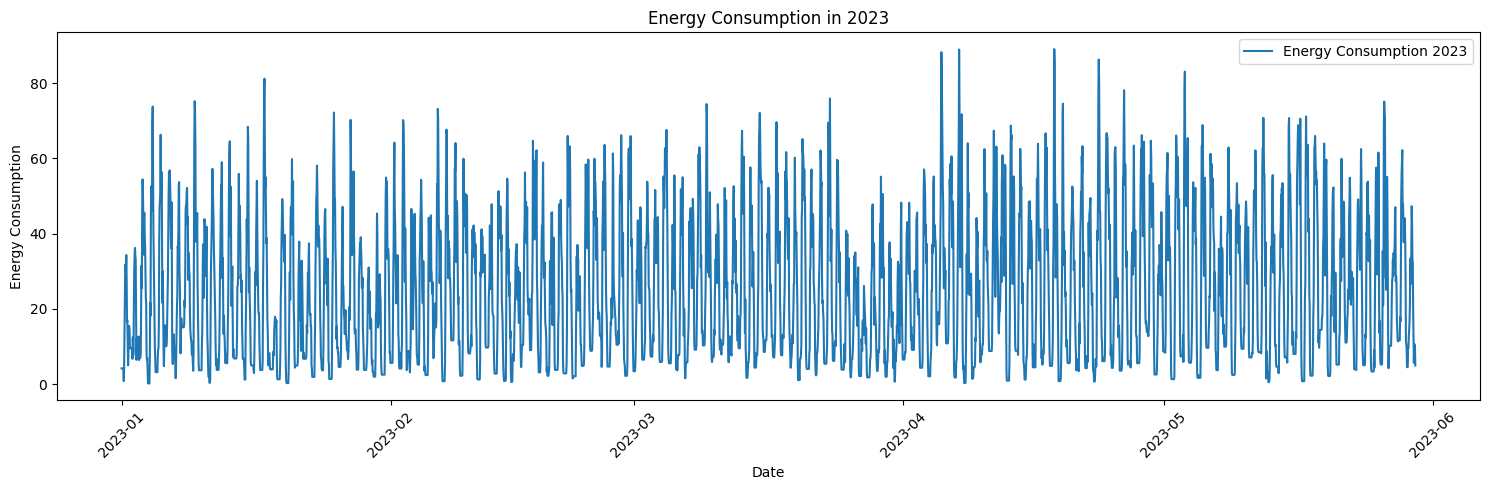

In [6]:
# Plot the different year in their own plot 
for year in final_df['Year'].unique():
    plt.figure(figsize=(15, 5))
    plt.plot(final_df[feature_df['Year'] == year].index, final_df[final_df['Year'] == year]['Energy_Consumption'], label=f'Energy Consumption {year}')
    plt.title(f'Energy Consumption in {year}')
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'../Rapport/Figures/Colorado/Energy_Consumption_{year}.png')
    plt.show()